In [2]:
class TreeNode(object):
    def __init__(self, X, y, childs=[], info=None, isLeaf=True, split_feature=None, split_value=None):
        self.X = X
        self.y = y
        self.isLeaf = isLeaf
        self.split_feature = split_feature
        self.split_value = split_value
        self.childs = childs
        self.info = info
        self.classes = np.unique(y)
        counter=[]
        for c in self.classes:
            counter.append(np.sum(y==c))
        self.class_ = self.classes[np.argmax(counter)]
    def predict_single(self, X):
        if self.isLeaf:
            return self.class_
        else:
            if ((type(self.split_value) == int) | (type(self.split_value) == float)):
                if (X[self.split_feature] >= self.split_value):
                    return self.childs[0].predict_single(X)
                else:
                    return self.childs[1].predict_single(X)
            else:
                if (X[self.split_feature] == self.split_value):
                    return self.childs[0].predict_single(X)
                else:
                    return self.childs[1].predict_single(X)
    def predict(self, X):
        if len(X.shape) > 0:
            y_temp = []
            for i in range(X.shape[0]):
                y_temp.append(self.predict_single(X[i]))
            return np.array(y_temp)
        else:
            return self.predict_single(X)

In [3]:
import numpy as np
class DecisionTree(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1, impurity_mode='gini', max_depth=5, min_gain=0.0):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.max_depth = max_depth
        self.min_gain = min_gain
        self.impurity_mode = impurity_mode
        # self.gini_max, self.entropy_max, self.classification_error_max = 0.5, 1.0, 0.5
        
    def impurity(self, y):
        if self.impurity_mode == 'gini':
            return self.gini(y)
        elif self.impurity_mode == 'entropy':
            return self.entropy(y)
        else:
            return self.classification_error(y)
        
    def gini(self, t):  # gini impuruty, t is the set of labels
        tags = np.unique(t)
        ig = 1
        for tag in tags:
            prob = np.sum(t==tag)/len(t)
            ig -= prob**(2)
        return ig 
    
    def entropy(self, t):
        tags = np.unique(t)
        en = 0
        for tag in tags:
            prob = np.sum(t==tag)/len(t)
            en -= prob*np.log2(prob)
        return en        
    
    def classification_error(self, t):
        tags = np.unique(t)
        prob = []
        for tag in tags:
            prob.append(np.sum(t==tag)/len(t))
        return 1-max(prob)
    
    def split(self, X, y, feature, value):  # binary split
        n_child = 2
        cX, cy = [], []
        childnode_X, childnode_y = [], []
        for _ in range(n_child):
            cX.append([])
            cy.append([])
        if ((type(value) == int) | (type(value) == float)):
            for i in range(X.shape[0]):
                if (X[i, feature] >= value):
                    cX[0].append(X[i])
                    cy[0].append(y[i])
                else:
                    cX[1].append(X[i])
                    cy[1].append(y[i])
        else:
            for i in range(X.shape[0]):
                if (X[i, feature] == value):
                    cX[0].append(X[i])
                    cy[0].append(y[i])
                else:
                    cX[1].append(X[i])
                    cy[1].append(y[i])
        for i in range(n_child):
            childnode_X.append(np.array(cX[i]))
            childnode_y.append(np.array(cy[i]))
        return childnode_X, childnode_y
    
    def build_decision_tree(self, X, y, depth=0):
        if depth==0:
            self.root = self.build_decision_tree(X, y, depth=1)
        else:
            impurity_current = self.impurity(y)
            gain_best, feature_best, value_best, child_best_X, child_best_y = 0.0, None, None, None, None
        
            n_features = X.shape[1]
            for feature in range(n_features):
                values_ = np.unique(X[:, feature])
                for value in values_:
                    childnode_X, childnode_y = self.split(X, y, feature, value)
                    p = len(childnode_y[0])/len(y)
                    info_gain = impurity_current - p * self.impurity(childnode_y[0]) - (1-p) * self.impurity(childnode_y[1])
                    if info_gain > gain_best:
                        gain_best, feature_best, value_best = info_gain, feature, value
                        child_best_X, child_best_y = childnode_X, childnode_y
        
            if gain_best > self.min_gain:
                info = (depth, impurity_current, (len(child_best_y[0]), len(child_best_y[1])))
                isnotLeaf = (depth <= self.max_depth) & (len(child_best_y[0])>0) & (len(child_best_y[1])>0)
                if isnotLeaf:
                    childs = []
                    for i in range(2):
                        childs.append(self.build_decision_tree(child_best_X[i], child_best_y[i], depth+1))
                    return TreeNode(X=X, y=y, childs=childs, info=info, isLeaf=False, split_feature=feature_best, split_value=value_best)
                else:
                    return TreeNode(X=X, y=y, info=info, isLeaf=True)
            else:
                return TreeNode(X=X, y=y, info=(depth, impurity_current, (-1, -1)), isLeaf=True)
    def predict(self, X):
        return self.root.predict(X)

In [4]:
import numpy as np
import pandas as pd  
df_trainX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_X_train.csv", header=0, error_bad_lines=False)
df_trainy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_y_train.csv", header=0, error_bad_lines=False)
df_testX = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_X_test.csv", header=0, error_bad_lines=False)
df_testy = pd.read_csv("/home/jiarui/Documents/3314/COMP3314_a1/dataset_files/car_y_test.csv", header=0, error_bad_lines=False)
X_train = df_trainX.iloc[:].values
y_train = df_trainy.iloc[:, 0].values 
X_test = df_testX.iloc[:].values
y_test = df_testy.iloc[:, 0].values

markers = ('o', 'x', 's', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
labels = np.unique(y_train)

In [5]:
dt = DecisionTree(max_depth=6)
dt.gini(y_train)

0.45210959162772174

In [6]:
dt.build_decision_tree(X_train, y_train)

In [7]:
y_pred = dt.predict(X_test)
test_error=(y_test!=y_pred).sum()
y_pred = dt.predict(X_train)
train_error=(y_train!=y_pred).sum()
print(train_error/len(y_train), test_error/len(y_test))

0.12076095947063689 0.12138728323699421


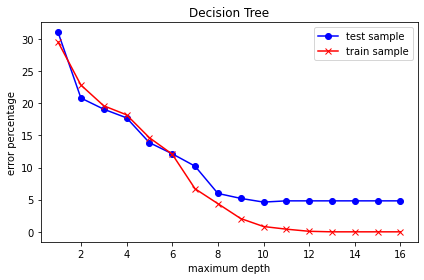

In [9]:
import matplotlib.pyplot as plt

max_depth = []
train_error = []
test_error = []
for i in range(16):
    max_depth.append(1+i)
    dt = DecisionTree(max_depth=max_depth[i])
    dt.build_decision_tree(X_train, y_train)
    y_pred = dt.predict(X_test)
    test_error.append((y_test!=y_pred).sum()/len(y_test)*100)
    y_pred = dt.predict(X_train)
    train_error.append((y_train!=y_pred).sum()/len(y_train)*100)

plt.figure()
plt.title("Decision Tree")
plt.xlabel('maximum depth')
plt.ylabel('error percentage')
plt.plot(max_depth, test_error, marker='o', color='blue', label='test sample')
plt.plot(max_depth, train_error, marker='x', color='red', label='train sample')
plt.legend(loc='upper right')
plt.tight_layout()  # auto adjust the layout of whole picture
plt.show()